# Importing the libraries.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#  Next Important step is Data Transformation.

#### We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

### Here is the list of all the transformations which come pre-built with PyTorch

#### Compose
#### ToTensor
#### ToPILImage
#### Normalize
#### Resize
#### Scale
#### CenterCrop
#### Pad
#### Lambda
#### RandomApply
#### RandomChoice
#### RandomOrder
#### RandomCrop
#### RandomHorizontalFlip
#### RandomVerticalFlip
#### RandomResizedCrop
#### RandomSizedCrop
#### FiveCrop
#### TenCrop
#### LinearTransformation
#### ColorJitter
#### RandomRotation
#### RandomAffine
#### Grayscale
#### RandomGrayscale
#### RandomPerspective
#### RandomErasing

## Transforming our data

### Now we will be normalizing our data and also will be converting our data into tensors hence first find out the mean and standard deviation of our data because those are the numbers we will need to supply in the Normalize function.

In [2]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Mean = 0.1307 and Standard Deviation = 0.3081

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(), # converting the images to tensors 
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [5]:
SEED = 1 # so that we get same random sample everytime.

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility --> so that we get same random sample everytime.
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics - They describe the overall data.

C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


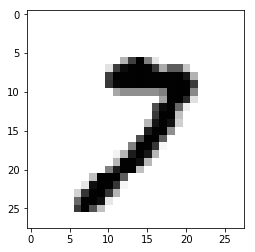

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[3].numpy().squeeze(), cmap='gray_r')


## It is important that we view as many images as possible. This is required to get some idea on image augmentation later on.

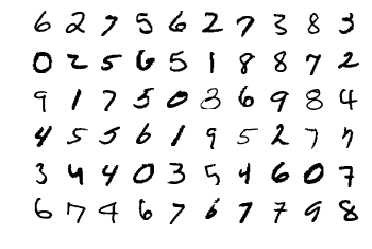

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) #input - 28*28*1 Output-26*26*32  RF-3*3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) #input - 26*26*32 Output-24*24*64  RF-5*5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # #input - 24*24*64 Output-22*22*128  RF-7*7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input - 22*22*128 Output- 11*11*128  RF-9*9
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) #input - 11*11*128 Output- 9*9*32  RF-11*11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) #input - 9*9*32 Output- 7*7*64  RF-15*15
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) #input - 7*7*64 Output- 5*5*128  RF-19*19

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) #input - 5*5*128 Output- 3*3*10  RF-23*23
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER! Use Relu on the last layer.
        ) #input - 3*3*10 Output- 1*1*10  RF-27*27

    def forward(self, x):
        x = self.convblock1(x) 
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## It is important to view the model summary and the model parameters and as there is not inbuilt function hence we do it using the following code

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [

### So we can see that we have  1,94,000 parameters which is also too much to be honest and thats alright we will try to improve on that slowly as we move ahead.¶


# Train and Test Functions.

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)  #nll means negative log loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.9808472990989685 Batch_id=468 Accuracy=24.06: 100%|███████████████████████████| 469/469 [00:08<00:00, 55.23it/s]



Test set: Average loss: 0.9839, Accuracy: 7085/10000 (70.85%)

EPOCH: 1


Loss=0.17543037235736847 Batch_id=468 Accuracy=89.97: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.00it/s]



Test set: Average loss: 0.1603, Accuracy: 9515/10000 (95.15%)

EPOCH: 2


Loss=0.11091768741607666 Batch_id=468 Accuracy=95.38: 100%|██████████████████████████| 469/469 [00:08<00:00, 53.90it/s]



Test set: Average loss: 0.1037, Accuracy: 9669/10000 (96.69%)

EPOCH: 3


Loss=0.12625302374362946 Batch_id=468 Accuracy=96.85: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.08it/s]



Test set: Average loss: 0.0768, Accuracy: 9745/10000 (97.45%)

EPOCH: 4


Loss=0.034082308411598206 Batch_id=468 Accuracy=97.51: 100%|█████████████████████████| 469/469 [00:08<00:00, 62.77it/s]



Test set: Average loss: 0.0640, Accuracy: 9786/10000 (97.86%)

EPOCH: 5


Loss=0.025693893432617188 Batch_id=468 Accuracy=97.98: 100%|█████████████████████████| 469/469 [00:08<00:00, 54.66it/s]



Test set: Average loss: 0.0455, Accuracy: 9846/10000 (98.46%)

EPOCH: 6


Loss=0.018284177407622337 Batch_id=468 Accuracy=98.26: 100%|█████████████████████████| 469/469 [00:08<00:00, 55.12it/s]



Test set: Average loss: 0.0462, Accuracy: 9863/10000 (98.63%)

EPOCH: 7


Loss=0.03200329840183258 Batch_id=468 Accuracy=98.49: 100%|██████████████████████████| 469/469 [00:08<00:00, 56.44it/s]



Test set: Average loss: 0.0485, Accuracy: 9838/10000 (98.38%)

EPOCH: 8


Loss=0.05599090829491615 Batch_id=468 Accuracy=98.61: 100%|██████████████████████████| 469/469 [00:08<00:00, 56.19it/s]



Test set: Average loss: 0.0449, Accuracy: 9858/10000 (98.58%)

EPOCH: 9


Loss=0.02647688426077366 Batch_id=468 Accuracy=98.77: 100%|██████████████████████████| 469/469 [00:08<00:00, 56.69it/s]



Test set: Average loss: 0.0358, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.03841133788228035 Batch_id=468 Accuracy=98.86: 100%|██████████████████████████| 469/469 [00:08<00:00, 56.41it/s]



Test set: Average loss: 0.0357, Accuracy: 9887/10000 (98.87%)

EPOCH: 11


Loss=0.0017653504619374871 Batch_id=468 Accuracy=98.96: 100%|████████████████████████| 469/469 [00:08<00:00, 56.31it/s]



Test set: Average loss: 0.0374, Accuracy: 9881/10000 (98.81%)

EPOCH: 12


Loss=0.0016876658191904426 Batch_id=468 Accuracy=99.00: 100%|████████████████████████| 469/469 [00:08<00:00, 56.29it/s]



Test set: Average loss: 0.0312, Accuracy: 9891/10000 (98.91%)

EPOCH: 13


Loss=0.030378157272934914 Batch_id=468 Accuracy=99.11: 100%|█████████████████████████| 469/469 [00:08<00:00, 56.38it/s]



Test set: Average loss: 0.0379, Accuracy: 9879/10000 (98.79%)

EPOCH: 14


Loss=0.012716834433376789 Batch_id=468 Accuracy=99.13: 100%|█████████████████████████| 469/469 [00:08<00:00, 62.05it/s]



Test set: Average loss: 0.0422, Accuracy: 9871/10000 (98.71%)

EPOCH: 15


Loss=0.05755322799086571 Batch_id=468 Accuracy=99.21: 100%|██████████████████████████| 469/469 [00:08<00:00, 62.22it/s]



Test set: Average loss: 0.0304, Accuracy: 9899/10000 (98.99%)

EPOCH: 16


Loss=0.002166335703805089 Batch_id=468 Accuracy=99.26: 100%|█████████████████████████| 469/469 [00:08<00:00, 56.04it/s]



Test set: Average loss: 0.0342, Accuracy: 9886/10000 (98.86%)

EPOCH: 17


Loss=0.016084611415863037 Batch_id=468 Accuracy=99.31: 100%|█████████████████████████| 469/469 [00:08<00:00, 56.24it/s]



Test set: Average loss: 0.0340, Accuracy: 9888/10000 (98.88%)

EPOCH: 18


Loss=0.004930893424898386 Batch_id=468 Accuracy=99.31: 100%|█████████████████████████| 469/469 [00:08<00:00, 55.74it/s]



Test set: Average loss: 0.0298, Accuracy: 9909/10000 (99.09%)

EPOCH: 19


Loss=0.11456653475761414 Batch_id=468 Accuracy=99.41: 100%|██████████████████████████| 469/469 [00:08<00:00, 56.24it/s]



Test set: Average loss: 0.0485, Accuracy: 9837/10000 (98.37%)



# Results :-

### 1.) Best Training Accuracy: 99.41%
### 2.) Best Test Accuracy : 99.01%
### 3.) Number of parameters : 194,000

### Number of parameters are still a lot for this model hence the model is still large and although we have reuced the overfitting still there is some overfitting in the model.

### Switch to Round 3 where we try to make furthur improvements.